In [23]:
%load_ext autoreload
%autoreload 2

## Utility for pre processing data and saving and loading the models

In [159]:
import numpy as np
import random
import unicodedata
import string
import glob

# Pre-processing of text
all_letters = string.printable
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if (unicodedata.category(c) != 'Mn' and c in all_letters))

def save(path, rnn):
    weights = {'U':rnn.U, 'V':rnn.V, 'W':rnn.W, 'b':rnn.b, 'c':rnn.c}
    np.save(path,weights)
    
def load(path, rnn):
    weights = np.load(path, allow_pickle=True)
    rnn.U = weights.item().get('U')
    rnn.V = weights.item().get('V')
    rnn.W = weights.item().get('W')
    rnn.b = weights.item().get('b')
    rnn.c = weights.item().get('c')
    return rnn

## RNN class with forward, backward, optimizer and sampling methods

In [135]:
# 1 layer, single batch

class RNN():
    def __init__(self, nx, nh, ny, layers, time_step, h_init):
        self.U = np.random.randn(nh,nx)*0.01
        self.V = np.random.randn(ny,nh)*0.01
        self.W = np.random.randn(nh,nh)*0.01
        self.b = np.random.randn(nh,1)
        self.c = np.random.randn(ny,1)
        
        self.layers = layers
        self.time_step = time_step
        self.nx = nx
        self.nh = nh
        self.train_loss = []
        self.train_acc = []
        
        # Adam optimiser terms
        self.Vdu = np.zeros_like(self.U)
        self.Vdv = np.zeros_like(self.V)
        self.Vdw = np.zeros_like(self.W)
        self.Vdb = np.zeros_like(self.b)
        self.Vdc = np.zeros_like(self.c)
        
        self.Sdu = np.zeros_like(self.U)
        self.Sdv = np.zeros_like(self.V)
        self.Sdw = np.zeros_like(self.W)
        self.Sdb = np.zeros_like(self.b)
        self.Sdc = np.zeros_like(self.c)

    def forward(self, X,Y,h_prev,U,V,W,b,c):
        '''
        capital X is list of indices and small x is one hot encoded
        X - input at timestep t (nx,1)
        Y - ground truth character sequence which is 1 shifted of X (nx,1)
        y - predicted output (nx,1)
        h_prev - hidden state at timestep t-1 (nh,1)
        U - input to hidden (nh,nx)
        V - hidden to output (ny,nh)
        W - hidden to hidden weight (nh,nh)
        b - Bias to calculate a (nh,1)
        c - Bias to calculate o (ny,1)
        '''
        x, h, y = {},{},{}
        h[-1] = np.copy(h_prev)
        loss = 0
        correct = 0
        
        for t in range(len(X)):  
            x[t] = np.zeros((self.nx,1)) # encode in 1-of-k representation
            x[t][X[t]] = 1
            a = np.dot(U, x[t]) + np.dot(W, h[t-1]) + b
            h[t] = np.tanh(a) # hidden state
            o = np.dot(V, h[t]) + c # unnormalized log probabilities for next chars
            y[t] = np.exp(o) / np.sum(np.exp(o)) # y[t] = probabilities for next chars
            
            loss += -np.log(y[t][Y[t],0]) # softmax (cross-entropy loss)
               # y[t] is array of size 1 x vocab_size, which has probability values for each of character
                # from vocab. And from that array, row at Y[t] and col at 0 is being picked, Y[t] is just a 
                # number index which is ground truth next character. Hence the CE loss is taken this way.
        
            if (y[t].argmax()==Y[t]):
                correct += 1
        
        self.acc = 100.*float(correct/len(X))
        self.loss = loss
        self.y = y
        self.X = X
        self.Y = Y
        self.h = h
        self.x = x
        self.h_prev = h[len(X)-1]
        return 
    
    def backward(self,val):
        y = self.y
        X = self.X
        Y = self.Y
        h = self.h
        x = self.x
        
        dU = np.zeros_like(self.U)
        dV = np.zeros_like(self.V)
        dW = np.zeros_like(self.W)
        db = np.zeros_like(self.b)
        dc = np.zeros_like(self.c)
        
        dhnext = np.zeros_like(h[0]) # For last time step this term is 0
        
        for t in reversed(range (len(X))): # During Backprop traversing from last time step
            dy = np.copy(y[t]) # dL/dy at any time step t is equal to y at that time step
            dy[Y[t]] -= 1 # Only at the index where y is one.. or where its the true label dL/dy = y-1
            
            dV += np.dot(dy, h[t].T)
            dc += dy
            
            dh = np.dot(self.V.T, dy) + dhnext
            dhTanh = (1 - h[t] * h[t]) * dh # backprop through tanh nonlinearity
            
            db += dhTanh
            dU += np.dot(dhTanh, x[t].T)
            dW += np.dot(dhTanh, h[t-1].T)
            dhnext = np.dot(self.W.T, dhTanh)
            
        # Clipping the gradients
        for params in dU,dV,dW,db,dc:
            np.clip(params, -5, 5,out=params)
            
        self.dU = dU
        self.dV = dV
        self.dW = dW
        self.db = db
        self.dc = dc
        self.h_prev = h[len(X)-1]
        return   
    
    def sgd_update_parameters(self, lr):
        self.U = self.U-lr*self.dU
        self.V = self.V-lr*self.dV
        self.W = self.W-lr*self.dW
        self.b = self.b-lr*self.db
        self.c = self.c-lr*self.dc
        return
    
    def adam_update_parameters(self, lr, beta1, beta2, t):
        epsilon = 1e-8
        corr_beta1 = 1-np.power(beta1,t+1)
        corr_beta2 = 1-np.power(beta2,t+1)
        
        self.Vdu = (beta1*self.Vdu + (1-beta1)*self.dU)
        self.Vdv = (beta1*self.Vdv + (1-beta1)*self.dV)
        self.Vdw = (beta1*self.Vdw + (1-beta1)*self.dW)
        self.Vdb = (beta1*self.Vdb + (1-beta1)*self.db)
        self.Vdc = (beta1*self.Vdc + (1-beta1)*self.dc)
        
        self.Sdu = beta2*self.Sdu + (1-beta2)*(self.dU**2)
        self.Sdv = beta2*self.Sdv + (1-beta2)*(self.dV**2)
        self.Sdw = beta2*self.Sdw + (1-beta2)*(self.dW**2)
        self.Sdb = beta2*self.Sdb + (1-beta2)*(self.db**2)
        self.Sdc = beta2*self.Sdc + (1-beta2)*(self.dc**2)
        
        Vdu = self.Vdu/corr_beta1
        Vdv = self.Vdv/corr_beta1
        Vdw = self.Vdw/corr_beta1
        Vdb = self.Vdb/corr_beta1
        Vdc = self.Vdc/corr_beta1
        
        Sdu = self.Sdu/corr_beta2
        Sdv = self.Sdv/corr_beta2
        Sdw = self.Sdw/corr_beta2
        Sdb = self.Sdb/corr_beta2
        Sdc = self.Sdc/corr_beta2
        
        self.U = self.U - lr*(Vdu/(np.sqrt(Sdu)+epsilon))
        self.V = self.V - lr*(Vdv/(np.sqrt(Sdv)+epsilon))
        self.W = self.W - lr*(Vdw/(np.sqrt(Sdw)+epsilon))
        self.b = self.b - lr*(Vdb/(np.sqrt(Sdb)+epsilon))
        self.c = self.c - lr*(Vdc/(np.sqrt(Sdc)+epsilon))
        return
        
    def rmsprop_update_parameters(self, lr, beta, t):
        epsilon = 1e-8
        corr_beta = 1-np.power(beta,t+1)
        
        self.Sdu = beta*self.Sdu + (1-beta)*(self.dU**2)
        self.Sdv = beta*self.Sdv + (1-beta)*(self.dV**2)
        self.Sdw = beta*self.Sdw + (1-beta)*(self.dW**2)
        self.Sdb = beta*self.Sdb + (1-beta)*(self.db**2)
        self.Sdc = beta*self.Sdc + (1-beta)*(self.dc**2)
                
        Sdu = self.Sdu/corr_beta
        Sdv = self.Sdv/corr_beta
        Sdw = self.Sdw/corr_beta
        Sdb = self.Sdb/corr_beta
        Sdc = self.Sdc/corr_beta
        
        self.U = self.U - lr*(self.dU/(np.sqrt(Sdu)+epsilon))
        self.V = self.V - lr*(self.dV/(np.sqrt(Sdv)+epsilon))
        self.W = self.W - lr*(self.dW/(np.sqrt(Sdw)+epsilon))
        self.b = self.b - lr*(self.db/(np.sqrt(Sdb)+epsilon))
        self.c = self.c - lr*(self.dc/(np.sqrt(Sdc)+epsilon))
        return
        
        
    def sample_input_longtext(self, h_prev, X, n, temperature=0.8):
        print('Initial Text = ',X)
        X = [vocab_to_index[i] for i in X]
        if (len(X)>1):
            self.forward(X,X,h_prev,self.U,self.V,self.W,self.b,self.c)
            h_prev = self.h_prev
        X_inp = X[-1]
                
        x = np.zeros((self.nx,1))
        x[X_inp] = 1
        indices = []
        
        for t in range(n):
            h = np.tanh(np.dot(self.U, x) + np.dot(self.W, h_prev) + self.b)
            y_logits = np.dot(self.V, h) + self.c
            y_logits = y_logits/temperature
            output = np.exp(y_logits) / np.sum(np.exp(y_logits))
            ix = np.random.choice(range(self.nx), p=output.ravel())
            x = np.zeros((self.nx, 1))
            x[ix] = 1
            indices.append(ix)
            h_prev = h
        return indices

## Training loop method

In [136]:
def train(data, index_to_vocab, vocab_to_index, num_iterations, nx,nh,ny,seq_length,layers,lr,max_value):
    max_iter = int(len(data)/seq_length)
    iteration = 0
    print('number of iterations of data = ',max_iter)
    max_iter = max(num_iterations,max_iter)
    print('max_iter = ',max_iter)
    h_init = np.zeros((nh,1))   
    rnn = RNN(nx, nh, ny, layers, seq_length, h_init)
    rnn.index_to_vocab = index_to_vocab

    start = 0
    smooth_loss = -np.log(1.0/nx)*seq_length # loss at iteration 0
    
    input_text_supervision = ['Har','Ro','Hagr','Hermi','Dumb','Sna','Hogw','Magic','Mugg','Weas','Pott','Poti',
                             'Dark','Avad','Sectum']
    
    while iteration < max_iter:
        
        if (start+seq_length+1 >= len(data)):
            start = 0
            print('starting back at 0')
        X = data[start : start+seq_length]
        Y = data[start+1 : start+seq_length+1]
        
        X = [vocab_to_index[i] for i in X]
        Y = [vocab_to_index[i] for i in Y]

        rnn.forward(X,Y,h_init,rnn.U,rnn.V,rnn.W,rnn.b,rnn.c)
        smooth_loss = smooth_loss * 0.999 + rnn.loss * 0.001
        rnn.backward(max_value)
        rnn.adam_update_parameters(lr, 0.9, 0.999, iteration)
        iteration +=1

        if (iteration%100==0):
            print('Iteration = ',iteration,'loss = ',smooth_loss/seq_length)
            rnn.train_loss.append(smooth_loss/seq_length)
            rnn.train_acc.append(rnn.acc)
            
            # Randomly choose some text starting from input_text_supervision list
            X_input = input_text_supervision[np.random.permutation(len(input_text_supervision))[0]]
#             X_input = [rnn.X[-1]]
            indices = rnn.sample_input_longtext(rnn.h_prev, X_input, 200)
            print('Generated text = ',(''.join([index_to_vocab[i] for i in indices])),'\n')
            
            # Save the rnn model
            save('Generation.npy',rnn)
            
        start += seq_length
        
        
    return rnn

## Main code to call the training method and fixing the hyperparameters

In [137]:
################ READING DATA ######################

filenames = glob.glob('./Harry Potter/Harry Potter 1 - Sorcerer\'s Stone.txt')

data = []
for filename in filenames:
    with open(filename, encoding = 'cp437') as f:
        text = f.read()
        ascii_text = unicodeToAscii(text)
        print('Number of Ascii characters in the file = ',filename,len(ascii_text))
        data.extend(ascii_text)

vocab = list(set(data))
print('Number of distinct characters in the vocabulary = ',len(vocab))
print('Total number of characters in all files = ',len(data))

index_to_vocab = {key:value for key, value in enumerate (vocab)}
vocab_to_index = {value:key for key, value in enumerate (vocab)}


################# INITIALIZE HYPERPARAMETERS ##################
nx = len(vocab)
nh = 256 # size of hidden layer of neurons
ny = nx
time_step = 20
layers = 1
lr = 1e-3
num_iter = 30000
max_value = 5

################# CALL THE TRAIN METHOD #########################
rnn = train(data, index_to_vocab, vocab_to_index, num_iter,nx,nh,ny,time_step,layers,lr,max_value)

Number of Ascii characters in the file =  ./Harry Potter/Harry Potter 1 - Sorcerer's Stone.txt 442745
Number of distinct characters in the vocabulary =  78
Total number of characters in all files =  442745
number of iterations of data =  22137
max_iter =  30000
Iteration =  100 loss =  4.250668268195584
Initial Text =  Mugg
Generated text =  e t hoao   .s  yniogeihsuuysnoriltlu
cuyws d'ois egc silopw wairpd  rs eedu h u eo g unua   t  r.ybmdr i  osnlrerils .o eotg   k hess e  l stduelntbiu m   r  sisrwe  p ua  srsnye lds  y rt   l s p  es 

Iteration =  200 loss =  4.138164833677274
Initial Text =  Dark
Generated text =  y a   gtm ayhntohe g uptDhhe hbse,rat ugwlnsehaa eoasPs l  in heto telinwltedeemhth h o  wheinn.ltn  t m  ta  ywtya  arthnthht l.ai p a rreae r  ehu rn aeeetumy twIrt t  wy tteciosl toe h ukmw-otsto w 

Iteration =  300 loss =  4.03271403865447
Initial Text =  Avad
Generated text =  mir enetho eiseet atld nae uh
t  aenmttw toee tea hernseitdee n ste alTea a iha mln  hh

Iteration =  2900 loss =  2.485348473746431
Initial Text =  Hogw
Generated text =  at the fart ans an wackid tont meat ot the Voin ntap hy hnown on Dunlit and snoc ananing ancy doon gas tea we tishing thot sithing an emon bick aing at ald anr ale soole suyin the bo boet ane and once 

Iteration =  3000 loss =  2.460651841931765
Initial Text =  Dumb
Generated text =  ey snther Am shiles th Harry ha canth theed sed Untle Varry in lern yost timass and ry.nTs sfounthen to thif camt mewep the noving then nh wry in thalry has dnglert th mnorry fine fost il the dundo th 

Iteration =  3100 loss =  2.4353757494846473
Initial Text =  Mugg
Generated text =  inked. 

Harlad ledn't alle withes dived sn'd aved on and snant ars wale? Uncle said at and thely tis tasked dwos, tunling tomaise tideth spaps as the warr. wis to totting gowand therp lowdtonlang wou 

Iteration =  3200 loss =  2.4144125042873017
Initial Text =  Sectum
Generated text =  ing Ha rra timid dur as waye hand and Uncle Vernow he D

Iteration =  5800 loss =  2.2343435967522174
Initial Text =  Ro
Generated text =  . Thet kithes sard blot," saif Rthemins llowes s te  f the fadn's fag bry's thee slys sthe gridcrs Coud loild tf plad pirs' lyers bet fors. Then ppeor, witheigs betse smile logsarry, sterce. The foret 

Iteration =  5900 loss =  2.238593007031237
Initial Text =  Sectum
Generated text =  bert sin looked t t ow in. At far cof now- of wint radpellid the wid the couvind thit winst of the Selt Harry mascerinmered stat the coutd peittlithe tha wathy rerilatle seek could aidingo dert allt l 

Iteration =  6000 loss =  2.2254914615751313
Initial Text =  Pott
Generated text =   on ald.. 

"Hagrsy, mowing stowed sou fond thingly lyon' se thed thot Hagrid, yeed," said, shinm had the say, extenched that dusted the sting yound and, wlorked sted ullidn's byed wand Hagd ans y aop 

Iteration =  6100 loss =  2.2151073942998023
Initial Text =  Hogw
Generated text =  ard in the serer tit inched heom ditesin' fut ye bachnd 

Iteration =  8700 loss =  2.1052078161775594
Initial Text =  Har
Generated text =  y. sharry thum medn she Creing the gaping tho the An the nhost payger thougs tim the coutclogrcabrut shas boll hams of- he ward elong now cho booking talles llive toud. It the dnase surpllus gokng wis 

Iteration =  8800 loss =  2.110422636233608
Initial Text =  Hogw
Generated text =  est bedfon ne snopeas at twiend gate fpocken Potsont, pad, patsed ther is an th ar as he scemple. Af! bed it pbotst hive in im thes noke, feepeed pomatined ther ht earens theer hal pbyobl he wan lut e 

Iteration =  8900 loss =  2.1095304571859046
Initial Text =  Hogw
Generated text =   tref nottors. 
A pick anchos," said the reace the gooded sead ticared. 

"I'vered, and dighoeg tat on the waserep at inker, late sexted. 

"I's deased peome ale and hice's up had the puoded Seetle -- 

Iteration =  9000 loss =  2.118557163368319
Initial Text =  Magic
Generated text =  omacen in Grofing, the was maghing so ungrespore alaig tr

Iteration =  11600 loss =  2.0000862926989136
Initial Text =  Weas
Generated text =  ." 

Harry would gaves did caid up all korit, sed but tiglnd it was thaind bou!" sor ame bofdund hiv was seedeny him moop, you seestoug in vourred taked out hirring." 

For intiog. "I moor. Ho masn'd  

Iteration =  11700 loss =  1.9965650084944144
Initial Text =  Sna
Generated text =  dlle back apoly greething thoudled read was the dwas forried ablang the suclt in the us mist. 

Harbous leag som the geat of whea thing able. 

Anct chell or a said to some shat rare as caren a the wa 

Iteration =  11800 loss =  1.9957528021395512
Initial Text =  Dark
Generated text =  , and Goy here int. 

"What's in the Grofed on tow. 

"Oht elfoyes acrsing, what's steaty tvely onet a dyou wnot thin'ser. 

"Wet Harry was at Harry. 

"Phat the saiteering Ron a whey not anded on the 

Iteration =  11900 loss =  1.990176434324558
Initial Text =  Mugg
Generated text =  ing broomst the he the doond of the thest mort whel i

Iteration =  14500 loss =  1.9511103306997182
Initial Text =  Dark
Generated text =  . 

Where simely hid ind and Gorr, as hed sem the clitten. Harry, weard said Find it yis melled over over every his hey tor icking the chisked you's simaly. 

"This paner year enare Harry smistey in s 

Iteration =  14600 loss =  1.9610419687658556
Initial Text =  Hogw
Generated text =  eted cewn and the fice so what so your fice, a rear a the fastoor dote ferculdyst teerry sted doustea to so pumproup be bewled to frasser and the crreleans mamplemosand roamio to gote hes bo forly he  

Iteration =  14700 loss =  1.9541811345452025
Initial Text =  Sectum
Generated text =   as. 

Harry fourd Harry and himund the lead and who Find. He Fask as hit hadry dat sibindy hit hit cale the was timald at eopded to harry couch saim court lat a Harry saip the caming a that name as i 

Iteration =  14800 loss =  1.9498368704461437
Initial Text =  Hermi
Generated text =  n buke the fore one of he wnow in the bark and r

Iteration =  17400 loss =  1.8887590990636807
Initial Text =  Hermi
Generated text =  ng in the furning Melfey if you me bely the reast, try thoug to ting to good. 

"I was gothery tone to them Neville anng ie was to seed wery held the deaderyole some alatt and onk rass Profeesten in t 

Iteration =  17500 loss =  1.8834775014335914
Initial Text =  Pott
Generated text =  ing. 

"Wem, Hermiode bo they he puseed Prickle castlings loak. 

"You whene had shook of the it on the dow looked and themely. She was lofkl of beepieverying Flother hiss of the hime, hour there have 

Iteration =  17600 loss =  1.885680186448753
Initial Text =  Hagr
Generated text =  , charry knid the campery siblled andion -- as an wongever fas off verying all whatring frcandyillore his hend, back loas rorngo were ssull crombll not rack off and liblt bo hes as a dore him got as a 

Iteration =  17700 loss =  1.8804459791153927
Initial Text =  Hogw
Generated text =  ered to the wat lefedsaid howe read on, got nongere

Iteration =  20300 loss =  1.8226848503580229
Initial Text =  Sectum
Generated text =   the blace saye tert dong oncering drvering frien poace and him moteed across hat at Harry and he pare juatre Harryon to the whowe arm sermione's cheee. Ho and chatuw "on a rone I mune iched quived th 

Iteration =  20400 loss =  1.8269003148993224
Initial Text =  Poti
Generated text =  n his leepy cone arout a on the deacher dilley reined life to and wond will beanconlins! I boor, broors were safe out of the deyte not said Ron wother loowing got to we plel dione suren pumen the anot 

Iteration =  20500 loss =  1.8302171217098757
Initial Text =  Hermi
Generated text =  nd beclling, an a dean's lott be books frow at the Shit look and and didn't brent -- he paice ouftace thime nack of breary uxtered near as the Shourd they let of thr bett scronoth, Snape -- fow rovery 

Iteration =  20600 loss =  1.8284401639418828
Initial Text =  Hogw
Generated text =  r of bit hould Harry, rot it wiverealing stepper

Iteration =  23200 loss =  1.8372794103689998
Initial Text =  Sectum
Generated text =  . "But Dumbling half might shispey didn't knot nopdirs. Hoghle that the vind, Yem, his cang his nof said herm. Qumbledone, thinghe bling aly peally bibe!" 

"Dumfledore, in the be thing in the bry in  

Iteration =  23300 loss =  1.8419006303003307
Initial Text =  Poti
Generated text =  ng and very the hive ous uppentid was a and and he wild harre cant of could back. 

"Onalle, were wotter eare a less I a leker he lemo a meowed for the suse is he strank on the Mrmbed there gond of th 

Iteration =  23400 loss =  1.8355041047689131
Initial Text =  Sectum
Generated text =   somath like somettor ScGo on the thete calle pack -- and the to to the roken in Dunder or the sor McGonagall bo the bornor Slecke the strither off nowded buck atrs profes only sster and sule Hagrid o 

Iteration =  23500 loss =  1.8461830334204603
Initial Text =  Hagr
Generated text =  abyss. 

Ducallens. 

Year had what had forn. "

Iteration =  26100 loss =  1.88635540435765
Initial Text =  Weas
Generated text =  . 

"Conders. 

A" card jomw you down, down, wored aid mame be town told come, every dade tome long up a got said. "Could yeh --I 

"Welle Vernow. I. in' wizdown, searmad, as diden sid out a mill teat 

Iteration =  26200 loss =  1.8880685652043734
Initial Text =  Ro
Generated text =  m, a -- of the momentter lived a fight, yise was get -- at in' you dore. shoone, an' scartly now was stoundous on you lemesentse a bidy an' It ser yeh cleer an' dars an' yer geted af yea whice come of 

Iteration =  26300 loss =  1.8901463236017606
Initial Text =  Sna
Generated text =  te, seet wizh yer aet.. so wild of the berse, an' some said Bight he his nome ens of ere were mor exck oo whates. Smill ke our bealle themed a sight to kne sume op be he sye Dumble you ter be and himo 

Iteration =  26400 loss =  1.8790778982596599
Initial Text =  Sectum
Generated text =  ed a wizard. 

"Booked formin' peing........ 

"Boith 

Iteration =  29000 loss =  1.8555404862506175
Initial Text =  Pott
Generated text =  hing him nop che rirnon the boy now ic what ing on his care he had tspicky said. 

"Oh, Pryso want one of his haiden the roy way strating ine each sime you tert for the the sting growing io his say lo 

Iteration =  29100 loss =  1.8529879671335607
Initial Text =  Dumb
Generated text =  y his upryen, It've wither," said to the krowld on theh to let ond." 

"W ony. 

"I al a to the It Vorny. 

"Gooks pickl so nood to jetsed Foom that not oit." 

"You meay vorter bet not on the tranger 

Iteration =  29200 loss =  1.8377748107618879
Initial Text =  Sna
Generated text =  then' a bonger said Ron found he with a toongbas a preandded Rosher yiu get out of back on his sound out of the romeshiched Harry fom think hunding." 

"WI'ted. He he are as they, as a the trome lithe 

Iteration =  29300 loss =  1.8360664997034593
Initial Text =  Magic
Generated text =  hing said Ron hasing pood Ron-'s and in wisped at a

## Tuning the hyperparameters
Various configurations are tried and the loss and accuracy values for each setting is stored in a dictionary called Observations.npy. Then at then end, the loss curves are plotted by reading the values from this dictionary

In [138]:
observation = np.load('observation.npy',allow_pickle=True)
observation[()].update({'adam_1e-3,256,20':[rnn.train_loss, rnn.train_acc]})
np.save('observation.npy',observation)

## Loss plot for differenent hyperparameters, optimizers and Accuracy plot

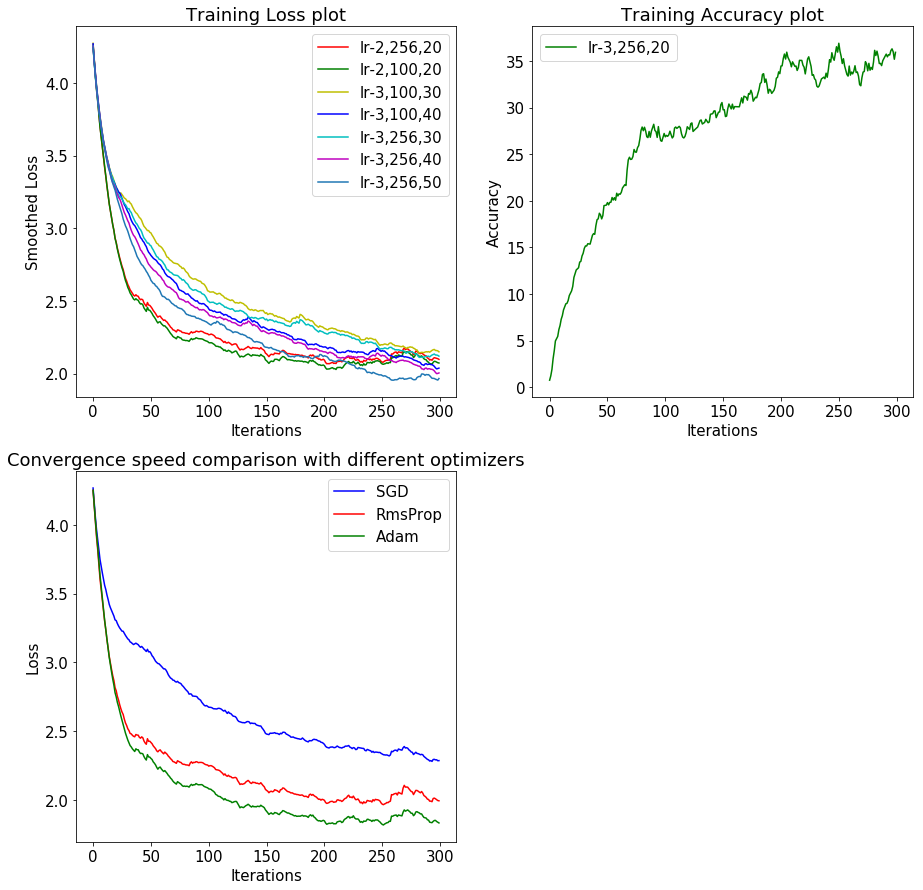

In [149]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(15,15))


observation = np.load('observation.npy',allow_pickle=True)
loss_2_256_20, acc_2_256_20 = observation.item().get('1e-2,256,20')[:2]
loss_2_100_20, acc_2_100_20 = observation.item().get('1e-2,100,20')

loss_100_30, acc_100_30 = observation.item().get('1e-3,100,30')
loss_100_40, acc_100_40 = observation.item().get('1e-3,100,40')

loss_256_20, acc_256_20 = observation.item().get('1e-3,256,20')[:2]
loss_256_30, acc_256_30 = observation.item().get('1e-3,256,30')
loss_256_40, acc_256_40 = observation.item().get('1e-3,256,40')
loss_256_50, acc_256_50 = observation.item().get('1e-3,256,50')


sgd = observation.item().get('1e-3,256,20')[0]
rmsprop = observation.item().get('rmsprop_1e-3,256,20')[0]
adam = observation.item().get('adam_1e-3,256,20')[0]


plt.subplot(221)
plt.gca().set_title('Training Loss plot')
plt.xlabel('Iterations')
plt.ylabel('Smoothed Loss')

plt.plot(np.arange(len(loss_2_256_20)),loss_2_256_20,c='r',label='lr-2,256,20')
plt.plot(np.arange(len(loss_2_100_20)),loss_2_100_20,c='g',label='lr-2,100,20')

plt.plot(np.arange(len(loss_100_30)),loss_100_30,c='y',label='lr-3,100,30')
plt.plot(np.arange(len(loss_100_40)),loss_100_40,c='b',label='lr-3,100,40')

plt.plot(np.arange(len(loss_256_30)),loss_256_30,c='c',label='lr-3,256,30')
plt.plot(np.arange(len(loss_256_40)),loss_256_40,c='m',label='lr-3,256,40')
plt.plot(np.arange(len(loss_256_50)),loss_256_50,label='lr-3,256,50')
plt.legend(loc="upper right")


plt.subplot(222)
plt.gca().set_title('Training Accuracy plot')
plt.plot(np.arange(len(acc_256_20)),acc_256_20,c='g',label='lr-3,256,20')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")


plt.subplot(223)
plt.gca().set_title('Convergence speed comparison with different optimizers')
plt.plot(np.arange(len(sgd)),sgd,c='b',label='SGD')
plt.plot(np.arange(len(rmsprop)),rmsprop,c='r',label='RmsProp')
plt.plot(np.arange(len(adam)),adam,c='g',label='Adam')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(loc="upper right")



plt.show()

## Generation of 1000 character string from trained model
We can vary the temperature values and generate text. We have given a small sentence as initial input to avoid zero initial activations.

In [162]:
# Generating 1000 character string

X_input = 'The hall immediately began to buzz excitedly; the Gryffindors were telling  the rest of the school what had just happened.'
indices = rnn.sample_input_longtext(rnn.h_prev, X_input, 1000, temperature=1)
print('Generated text = '+(''.join([index_to_vocab[i] for i in indices])))
           

Initial Text =  The hall immediately began to buzz excitedly; the Gryffindors were telling  the rest of the school what had just happened.
Generated text =  You'd meant, bo gicked borking a dudlyon' -- fhery been beell Conly? "She poched it, looks harwin facanMe gottee's said. 

"I ave terehtored Gookbehear?" 

"You,"ore fowing a wornd. 

"Gree peallade weale, )rever -- neelfey. Say porabessm the wate Frink a ling in. 

"I cant ee heabd inly, ween soew Wo him Rand Harry's knew to cuturain. "Gryer lothered the Shout in his feet need of, Gorou?" 

Alfey the twines a comarboy Ron camborser of Grylioked tollew. he bett in hid 't ouf som be saytleser ofr. Soyouprens, for, for. Sist with sayen it! Thaisils been exourione boy, becrecus." 

And seliesed o-then cofly, a pueper wizards and, My. Ex Did Ron-" Ron as Shagbers. 

"Sh, seround explan eroup to and to go it tin parking to alrembut I durry. "
he his pack't oulle ou? forn's eadt. 

"Unce be and So chacit? "e Wet Hermund Persadsether beet

## Small check to see how Temperature values affect the probabilities

In [40]:
a=[0.1,0.2,0.3,0.4,0.5]
a=np.exp(a)
a=a/np.sum(a)
print('Probabilities with no temperature value ',a)

b=[0.1,0.2,0.3,0.4,0.5]
b=[i/1.4 for i in b]
b=np.exp(b)
b=b/np.sum(b)
print('Probabilities with temperature value 1.4 ',b)

c=[0.1,0.2,0.3,0.4,0.5]
c=[i/0.6 for i in c]
c=np.exp(c)
c=c/np.sum(c)
print('Probabilities with temperature value 0.6 ',c)

Probabilities with no temperature value  [0.16212035 0.17917069 0.19801424 0.21883958 0.24185514]
Probabilities with temperature value 1.4  [0.17249423 0.18526595 0.19898331 0.21371632 0.22954018]
Probabilities with temperature value 0.6  [0.13940336 0.16468561 0.19455306 0.22983729 0.27152067]
